# Interpretable Object Detection

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import brambox as bb
import lightnet as ln
import interpretability as ip

## Settings and paths

In [2]:
# Settings
bb.logger.setConsoleLevel('ERROR')             # Only show error log messages

# Setting device
device = torch.device('cpu')
if torch.cuda.is_available():
    print('CUDA enabled')
    device = torch.device('cuda')
else:
    print('CUDA not available')
    
# Path variables
network_path = 'cfg/yolo.py'
annos_path = 'data/VOCdevkit/VOC2007/Annotations/'
weights_path = 'weights/yolov2-voc.pt'

CUDA enabled


## Picking interesting images

In [3]:
# Load annotations
anno = bb.io.load('pandas', 'data/annotations.pkl')
det = bb.io.load('pandas', 'data/detections_all.h5')

# Variables
detection_threshold = 0.5

my_class = 'horse' # Which class to look at
# aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor

anno = anno[anno['class_label'] == my_class]
det = det[det['class_label'] == my_class]

# Filter detections based on threshold (computed in previous step from F1-curve)
filtered_det = det[det.confidence >= detection_threshold].copy()

display(filtered_det[filtered_det.confidence == filtered_det.confidence.max()])

# Compute TP,FP
tpfp_det = bb.stat.match_det(filtered_det, anno, 0.1, ignore=bb.stat.IgnoreMethod.SINGLE)
# match_det() returns detections with a 'tp' and 'fp' column.
print('TP FP:')
tpfp_det = tpfp_det[tpfp_det['fp']]
tpfp_det = tpfp_det.drop_duplicates(['image'])
display(tpfp_det.sort_values(['confidence'], ascending=False))
chosen_images = tpfp_det.image

# Compute FN
fn_anno = bb.stat.match_anno(filtered_det, anno, 0.5, ignore=bb.stat.IgnoreMethod.SINGLE)
# match_anno() returns annotations with a 'detection' column that has the index of the matched detection
# We use this to filter unmatched annotations (NaN as index)
fn_anno = fn_anno[fn_anno.detection.isnull()]
fn_anno = fn_anno[~fn_anno['ignore']]
fn_anno = fn_anno.drop_duplicates(['image'])
print('FN:')
display(fn_anno)
"""chosen_images = chosen_images.append(fn_anno.image)"""
#chosen_images = fn_anno.image

,image,class_label,id,x_top_left,y_top_left,width,height,confidence
22742,VOC2007/JPEGImages/001013,horse,NaN,220.891696,18.170412,271.930419,317.83258,0.978928


TP FP:


,image,class_label,id,x_top_left,y_top_left,width,height,confidence,tp,fp
537,VOC2007/JPEGImages/000025,horse,NaN,65.874246,157.646198,299.785431,219.981157,0.893297,False,True
12500,VOC2007/JPEGImages/000539,horse,NaN,100.851499,231.702181,392.355039,134.383944,0.874200,False,True
42168,VOC2007/JPEGImages/001839,horse,NaN,76.196359,154.532506,205.679050,198.225847,0.779080,False,True
72074,VOC2007/JPEGImages/003179,horse,NaN,240.933785,160.714956,191.088090,133.356690,0.775544,False,True
92999,VOC2007/JPEGImages/004084,horse,NaN,178.574712,94.721515,102.155562,120.389440,0.760733,False,True
103892,VOC2007/JPEGImages/004545,horse,NaN,142.315470,197.268945,60.288819,157.243399,0.681248,False,True
22068,VOC2007/JPEGImages/000978,horse,NaN,99.954275,280.422357,373.078236,93.400433,0.654746,False,True
224429,VOC2007/JPEGImages/009843,horse,NaN,1.984780,51.734521,351.892875,453.713197,0.640023,False,True
37312,VOC2007/JPEGImages/001641,horse,NaN,-1.074974,89.878642,91.634219,290.215547,0.619093,False,True
34255,VOC2007/JPEGImages/001508,horse,NaN,114.258950,252.391448,272.104172,252.339363,0.611070,False,True


FN:


,image,class_label,id,x_top_left,y_top_left,width,height,occluded,truncated,lost,difficult,ignore,detection,criteria
647,VOC2007/JPEGImages/000412,horse,0,57.000000,100.000000,339.0,217.0,1.0,0.0,False,False,False,NaN,0.0
651,VOC2007/JPEGImages/000413,horse,0,159.000000,6.000000,285.0,359.0,1.0,0.0,False,False,False,NaN,0.0
732,VOC2007/JPEGImages/000475,horse,0,328.000000,85.000000,36.0,49.0,0.0,0.0,False,False,False,NaN,0.0
1097,VOC2007/JPEGImages/000704,horse,0,13.000000,81.000000,223.0,261.0,0.0,0.0,False,False,False,NaN,0.0
1151,VOC2007/JPEGImages/000737,horse,0,255.000000,123.201923,147.0,138.0,0.0,0.0,False,False,False,NaN,0.0
1851,VOC2007/JPEGImages/001245,horse,0,3.000000,123.000000,31.0,94.0,0.0,0.0,False,False,False,NaN,0.0
2382,VOC2007/JPEGImages/001574,horse,0,32.201923,119.000000,184.0,382.0,1.0,0.0,False,False,False,NaN,0.0
2477,VOC2007/JPEGImages/001635,horse,0,134.000000,142.000000,22.0,31.0,0.0,0.0,False,False,False,NaN,0.0
2962,VOC2007/JPEGImages/001955,horse,0,212.000000,178.000000,37.0,49.0,0.0,0.0,False,False,False,NaN,0.0
3103,VOC2007/JPEGImages/002071,horse,0,226.000000,139.201923,145.0,112.0,0.0,0.0,False,False,False,NaN,0.0


'chosen_images = chosen_images.append(fn_anno.image)'

## Run Backprogation

INFO       Loading weights from file [weights/yolov2-voc.pt]


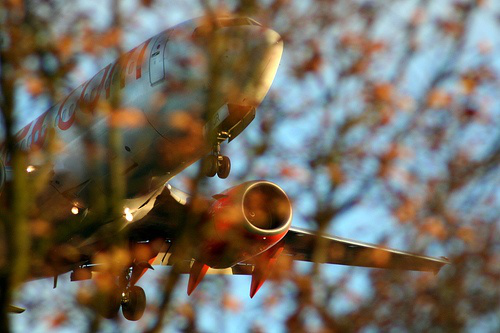

Detections:


,image,class_label,x_top_left,y_top_left,width,height,confidence,anchor_box,status
0,VOC2007/JPEGImages/000600,aeroplane,0.832,78.152,373.568,258.752,,,FN


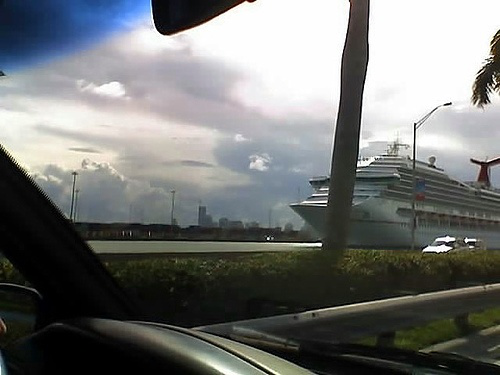

Detections:


,image,class_label,x_top_left,y_top_left,width,height,confidence,anchor_box,status
0,VOC2007/JPEGImages/000529,boat,241.280,170.976,174.720,89.024,,,FN
1,VOC2007/JPEGImages/000529,car,351.104,249.184,32.448,14.976,,,FN


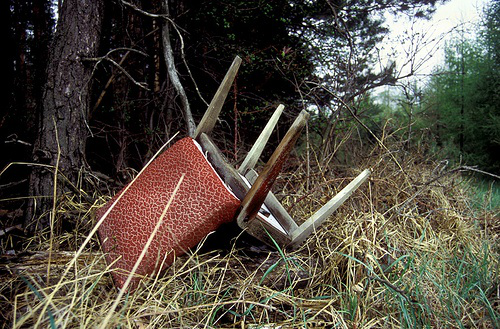

Detections:


,image,class_label,x_top_left,y_top_left,width,height,confidence,anchor_box,status
0,VOC2007/JPEGImages/002928,chair,77.376,116.76,232.96,197.184,,,FN


In [4]:
# Initialize network and load weights
params = ln.engine.HyperParameters.from_file(network_path)
params.network.load(weights_path)

# Vanilla backprop
VBP = ip.backprop.VanillaBackprop(params, device)

# Guided backprop
GBP = ip.backprop.GuidedBackprop(params, device)

gradients_as_arr_list = []
count_list = []
img_tf_list = []
#chosen_images = ['VOC2007/JPEGImages/008481', 'VOC2007/JPEGImages/003843', 'VOC2007/JPEGImages/001503', 'VOC2007/JPEGImages/008020', 'VOC2007/JPEGImages/008761', 'VOC2007/JPEGImages/003650', 'VOC2007/JPEGImages/005162', 'VOC2007/JPEGImages/001984', 'VOC2007/JPEGImages/008652', 'VOC2007/JPEGImages/007444', 'VOC2007/JPEGImages/001208', 'VOC2007/JPEGImages/009040', 'VOC2007/JPEGImages/000488', 'VOC2007/JPEGImages/000893', 'VOC2007/JPEGImages/004899', 'VOC2007/JPEGImages/004877', 'VOC2007/JPEGImages/002075', 'VOC2007/JPEGImages/001278', 'VOC2007/JPEGImages/007420', 'VOC2007/JPEGImages/002013', 'VOC2007/JPEGImages/007574', 'VOC2007/JPEGImages/005926', 'VOC2007/JPEGImages/004646', 'VOC2007/JPEGImages/007265', 'VOC2007/JPEGImages/008637', 'VOC2007/JPEGImages/007703', 'VOC2007/JPEGImages/004546', 'VOC2007/JPEGImages/001666', 'VOC2007/JPEGImages/002639', 'VOC2007/JPEGImages/003411',' VOC2007/JPEGImages/005444', 'VOC2007/JPEGImages/004798', 'VOC2007/JPEGImages/009352', 'VOC2007/JPEGImages/004772', 'VOC2007/JPEGImages/001973', 'VOC2007/JPEGImages/007634', 'VOC2007/JPEGImages/007941', 'VOC2007/JPEGImages/001508', 'VOC2007/JPEGImages/009843', 'VOC2007/JPEGImages/007866', 'VOC2007/JPEGImages/008734', 'VOC2007/JPEGImages/005294', 'VOC2007/JPEGImages/004920', 'VOC2007/JPEGImages/009344', 'VOC2007/JPEGImages/001701', 'VOC2007/JPEGImages/003805', 'VOC2007/JPEGImages/009689', 'VOC2007/JPEGImages/000751', 'VOC2007/JPEGImages/005891', 'VOC2007/JPEGImages/001462', 'VOC2007/JPEGImages/001306', 'VOC2007/JPEGImages/005452', 'VOC2007/JPEGImages/005934', 'VOC2007/JPEGImages/006528', 'VOC2007/JPEGImages/001773', 'VOC2007/JPEGImages/009235', 'VOC2007/JPEGImages/003342', 'VOC2007/JPEGImages/003571', 'VOC2007/JPEGImages/007549', 'VOC2007/JPEGImages/006633', 'VOC2007/JPEGImages/007717']
#chosen_images = ['VOC2007/JPEGImages/000600', 'VOC2007/JPEGImages/005376', 'VOC2007/JPEGImages/008986' , 'VOC2007/JPEGImages/000529', 'VOC2007/JPEGImages/001141',' VOC2007/JPEGImages/001006', 'VOC2007/JPEGImages/002075', 'VOC2007/JPEGImages/002892', 'VOC2007/JPEGImages/004373', 'VOC2007/JPEGImages/007000',' VOC2007/JPEGImages/007512', 'VOC2007/JPEGImages/000893', 'VOC2007/JPEGImages/001407', 'VOC2007/JPEGImages/003076', 'VOC2007/JPEGImages/005936', 'VOC2007/JPEGImages/007778','VOC2007/JPEGImages/008212',  'VOC2007/JPEGImages/001616',  'VOC2007/JPEGImages/000517', 'VOC2007/JPEGImages/001075',' VOC2007/JPEGImages/001313', 'VOC2007/JPEGImages/001462',' VOC2007/JPEGImages/005538', 'VOC2007/JPEGImages/009352', 'VOC2007/JPEGImages/001957', 'VOC2007/JPEGImages/002928', 'VOC2007/JPEGImages/003222']
chosen_images = ['VOC2007/JPEGImages/000600', 'VOC2007/JPEGImages/000529', 'VOC2007/JPEGImages/002928']

for image in chosen_images:
    # New path
    new_path = annos_path + image.split('/')[-1] + '.xml'
    
    # Load annos
    annos = bb.io.load('anno_pascalvoc', new_path, ip.identify)
    #annos = annos[annos['class_label'] == my_class]
    
    # Get detections
    det_img, detections = ip.run_detect(params, new_path, device, detection_threshold)
    display(ip.utils.show_image(det_img))
    detections.image = image
    detections.image = detections.image.astype('category')
    #detections = detections[detections['class_label'] == my_class]
    
    # Run model
    img_tf, annos = ip.transform(params, annos, new_path)

    # Compute TP,FP
    tpfp_det = bb.stat.match_det(detections, annos, 0.5, ignore=bb.stat.IgnoreMethod.SINGLE)
    # match_det() returns detections with a 'tp' and 'fp' column.

    # Compute FN
    fn_anno = bb.stat.match_anno(detections, annos, 0.5, ignore=bb.stat.IgnoreMethod.SINGLE)
    # match_anno() returns annotations with a 'detection' column that has the index of the matched detection
    # We use this to filter unmatched annotations (NaN as index)
    fn_anno = fn_anno[fn_anno.detection.isnull()]
    
    # Add status column
    tpfp_det['status'] = 'FP'                     # Make all boxes FP
    tpfp_det.loc[tpfp_det.tp, 'status'] = 'TP'  # Make TP boxes TP
    fn_anno['status'] = 'FN'                     # Make FN boxes FN
    
    # Add extra columns to fn_anno to be able to combine dataframes
    fn_anno['anchor_box'] = ''
    fn_anno['confidence'] = ''

    # Only keep necessary columns (to be able to combine dataframes)
    boxes1 = tpfp_det[['image', 'class_label', 'x_top_left', 'y_top_left', 'width', 'height', 'confidence', 'anchor_box', 'status']]
    boxes2 = fn_anno[['image', 'class_label', 'x_top_left', 'y_top_left', 'width', 'height', 'confidence', 'anchor_box', 'status']]

    # Concatenate dataframes
    boxes = bb.util.concat([boxes1, boxes2], sort=False, ignore_index=True)
    
    print('Detections:')
    display(boxes)

    # Generate gradients
    gradients_as_arr = VBP.generate_gradients(params, img_tf, device, boxes, True, True)
    img_tf_list.append(img_tf.data.cpu().numpy()[0])
    count_list.append(len(gradients_as_arr))
    for gradient in gradients_as_arr:
        gradients_as_arr_list.append(gradient)
        
    """# Generate gradients
    gradients_as_arr = GBP.generate_gradients(params, img_tf, device, boxes, True, True)
    for gradient in gradients_as_arr:
        gradients_as_arr_list.append(gradient)"""

## Show images on screen

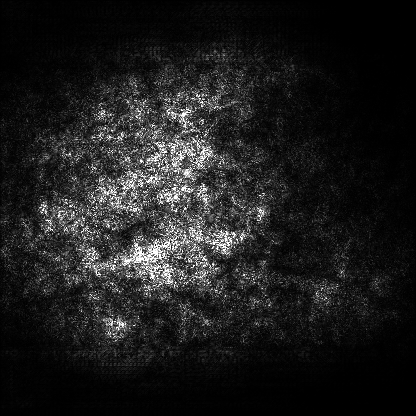

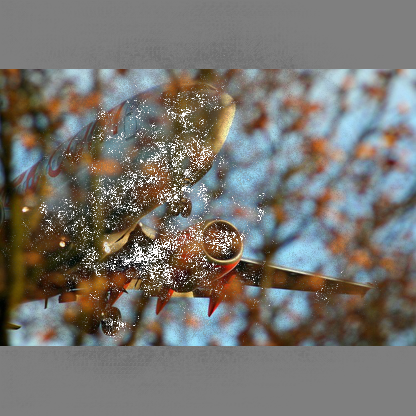

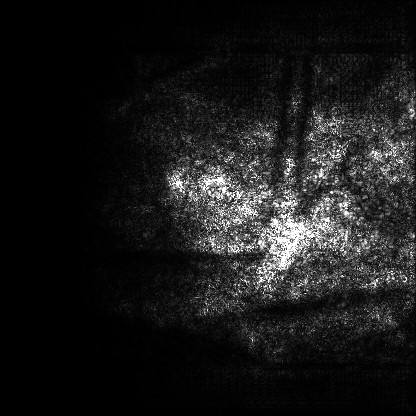

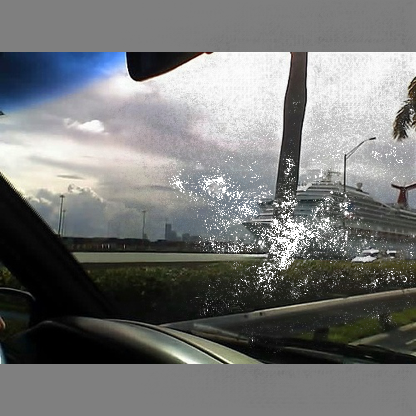

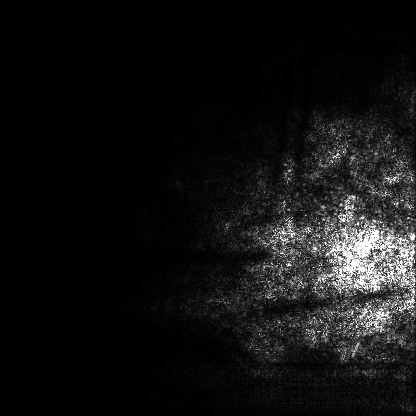

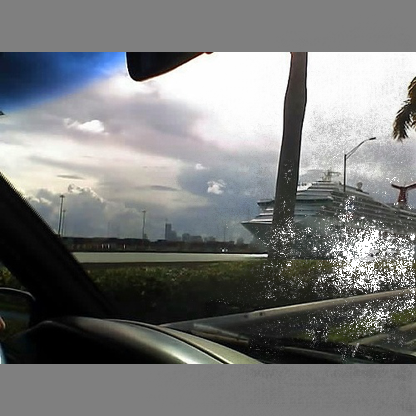

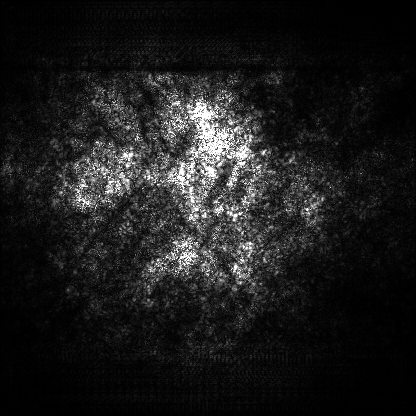

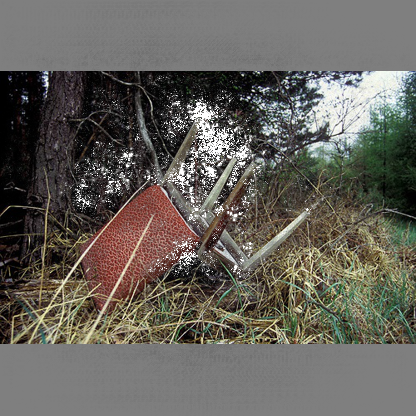

In [5]:
# Normalize to grayscale and show images
gradients_list = []
#gradients_list = ip.utils.normalize(gradients_as_arr_list, True)
for immm in gradients_as_arr_list:
    gradients_list.append(ip.utils.convert_to_grayscale(immm))
count1 = 0
count2 = 0

for gradient in gradients_list:
    if count1 == count_list[count2]:
        count2 += 1
        count1 = 0
    img = ip.utils.show_image(gradient).convert("L")
    display(img)
    img_tf_show = ip.utils.show_image(img_tf_list[count2])
    img_tf_show.paste(img, (0, 0), img)
    display(img_tf_show)
    count1 += 1

# End